## Libraries

In [26]:
!pip install opencv-python
!pip install tensorflow

In [27]:
import os
import PIL
import cv2
import uuid
import shutil
import random
import glob as gb
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from tqdm import tqdm  # Progress bar
from scipy.special import gamma

from keras.optimizers import *
from keras.regularizers import l1_l2
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler
from keras.layers import Conv2D, MaxPool2D, BatchNormalization

from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

## Data processing

In [28]:
import zipfile

zip_path = '/content/classification.zip'
extract_path = '/content'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete.")

Extraction complete.


In [29]:
zero_class_count = len(os.listdir("/content/classification/0"))
one_class_count  = len(os.listdir("/content/classification/1"))

print(f"Number of images in class 0: {zero_class_count}")
print(f"Number of images in class 1: {one_class_count}")

Number of images in class 0: 4199
Number of images in class 1: 4198


In [30]:
import tensorflow as tf

data_dir = '/content/classification'  # Update with the dataset path

# Create a dataset for the entire data to use for split
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    # image_size=(224, 224),
    image_size=(224, 224),
    seed=50,
    shuffle=True,
    batch_size=16
)
# Calculate the total number of samples
total_samples = tf.data.experimental.cardinality(full_dataset).numpy()

train_size = int(0.8 * total_samples)                 # 70% for training
val_size   = int(0.15 * total_samples)                # 20% for validation
test_size = total_samples - train_size - val_size     # 10% for testing

# Create train, validation, and test datasets
train_dataset       = full_dataset.take(train_size)
validation_dataset  = full_dataset.skip(train_size).take(val_size)
test_dataset        = full_dataset.skip(train_size + val_size)

train_dataset      = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset       = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Print the number of samples in each dataset
print(f"Train samples:      {train_size}     batches(16) ==> {train_size*16}")
print(f"Validation samples: {val_size}       batches(16) ==> {val_size*16}")
print(f"Test samples:       {test_size}      batches(16) ==> {test_size*16}")

Found 8397 files belonging to 2 classes.
Train samples:      420     batches(16) ==> 6720
Validation samples: 78       batches(16) ==> 1248
Test samples:       27      batches(16) ==> 432


## VGG16 Model

### Without pre-trained models : Base Model

In [31]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam

base_vgg = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))

# Unfreeze last 8 convolutional layers
for layer in base_vgg.layers[:-12]:
    layer.trainable = False
for layer in base_vgg.layers[-12:]:
    layer.trainable = True

model_vgg = models.Sequential([
    base_vgg,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model_vgg.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_vgg.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,242,050 (58.14 MB)

 Trainable params: 14,981,890 (57.15 MB)

 Non-trainable params: 260,160 (1016.25 KB)

In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_file = "best_vgg_model.h5"

callbacks = [
    ModelCheckpoint(checkpoint_file, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
]


In [33]:
history_vgg = model_vgg.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=7,
    batch_size=16,
    callbacks=callbacks
)


Epoch 1/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.5103 - loss: 0.7167
Epoch 1: val_accuracy improved from -inf to 0.57532, saving model to best_vgg_model.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 95s 199ms/step - accuracy: 0.5103 - loss: 0.7167 - val_accuracy: 0.5753 - val_loss: 0.6888
Epoch 2/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.5615 - loss: 0.6803
Epoch 2: val_accuracy improved from 0.57532 to 0.58173, saving model to best_vgg_model.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 85s 202ms/step - accuracy: 0.5616 - loss: 0.6803 - val_accuracy: 0.5817 - val_loss: 0.6718
Epoch 3/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6109 - loss: 0.6565
Epoch 3: val_accuracy improved from 0.58173 to 0.66907, saving model to best_vgg_model.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 86s 204ms/step - accuracy: 0.6110 - loss: 0.6565 - val_accuracy: 0.6691 - val_loss: 0.6134
Epoch 4/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6623 - loss: 0.6260
Epoch 4: val_accuracy did not improve from 0.66907
420/420 ━━━━━━━━━━━━━━━━━━━━ 87s 207ms/step - accuracy: 0.6623 - loss: 0.6259 - val_accuracy: 0.6434 - val_loss: 0.6638
Epoch 5/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6708 - loss: 0.6145
Epoch 5: val_accuracy improved from 0.66907 to 0.67628, saving model to best_vgg_model.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 87s 206ms/step - accuracy: 0.6708 - loss: 0.6145 - val_accuracy: 0.6763 - val_loss: 0.6123
Epoch 6/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6773 - loss: 0.6034
Epoch 6: val_accuracy did not improve from 0.67628
420/420 ━━━━━━━━━━━━━━━━━━━━ 86s 205ms/step - accuracy: 0.6773 - loss: 0.6034 - val_accuracy: 0.6747 - val_loss: 0.6187
Epoch 7/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6862 - loss: 0.5992
Epoch 7: val_accuracy improved from 0.67628 to 0.68189, saving model to best_vgg_model.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 86s 206ms/step - accuracy: 0.6863 - loss: 0.5992 - val_accuracy: 0.6819 - val_loss: 0.6138


In [34]:
from tensorflow.keras.models import load_model

# Load the best model saved by ModelCheckpoint
best_vgg_model = load_model("best_vgg_model.h5")

# Evaluate on the test set
test_loss, test_acc = best_vgg_model.evaluate(test_dataset)
print(f"Best VGG Test Accuracy: {test_acc:.4f}")


27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.7247 - loss: 0.5774
Best VGG Test Accuracy: 0.7156


### With pre-trained model : ImageNet

In [35]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam

base_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze last 8 convolutional layers
for layer in base_vgg.layers[:-12]:
    layer.trainable = False
for layer in base_vgg.layers[-12:]:
    layer.trainable = True

model_vgg = models.Sequential([
    base_vgg,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model_vgg.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_vgg.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,242,050 (58.14 MB)

 Trainable params: 14,981,890 (57.15 MB)

 Non-trainable params: 260,160 (1016.25 KB)

In [36]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_file = "best_vgg_model_preTrained.h5"

callbacks = [
    ModelCheckpoint(checkpoint_file, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
]


In [37]:
history_vgg_preTrained = model_vgg.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=7,
    batch_size=16,
    callbacks=callbacks
)


Epoch 1/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.5184 - loss: 0.7813
Epoch 1: val_accuracy improved from -inf to 0.62981, saving model to best_vgg_model_preTrained.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 94s 210ms/step - accuracy: 0.5184 - loss: 0.7811 - val_accuracy: 0.6298 - val_loss: 0.6713
Epoch 2/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.6491 - loss: 0.6477
Epoch 2: val_accuracy improved from 0.62981 to 0.69391, saving model to best_vgg_model_preTrained.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 87s 208ms/step - accuracy: 0.6492 - loss: 0.6477 - val_accuracy: 0.6939 - val_loss: 0.5859
Epoch 3/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.6866 - loss: 0.5900
Epoch 3: val_accuracy improved from 0.69391 to 0.70032, saving model to best_vgg_model_preTrained.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 88s 210ms/step - accuracy: 0.6866 - loss: 0.5900 - val_accuracy: 0.7003 - val_loss: 0.5880
Epoch 4/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.7208 - loss: 0.5570
Epoch 4: val_accuracy improved from 0.70032 to 0.70192, saving model to best_vgg_model_preTrained.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 88s 209ms/step - accuracy: 0.7209 - loss: 0.5570 - val_accuracy: 0.7019 - val_loss: 0.5505
Epoch 5/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.7465 - loss: 0.5173
Epoch 5: val_accuracy improved from 0.70192 to 0.74038, saving model to best_vgg_model_preTrained.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 88s 209ms/step - accuracy: 0.7465 - loss: 0.5173 - val_accuracy: 0.7404 - val_loss: 0.5458
Epoch 6/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.7721 - loss: 0.4825
Epoch 6: val_accuracy improved from 0.74038 to 0.75160, saving model to best_vgg_model_preTrained.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 142s 210ms/step - accuracy: 0.7722 - loss: 0.4824 - val_accuracy: 0.7516 - val_loss: 0.5762
Epoch 7/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.7914 - loss: 0.4372
Epoch 7: val_accuracy improved from 0.75160 to 0.75801, saving model to best_vgg_model_preTrained.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 142s 210ms/step - accuracy: 0.7914 - loss: 0.4371 - val_accuracy: 0.7580 - val_loss: 0.5867


In [38]:
from tensorflow.keras.models import load_model

# Load the best model saved by ModelCheckpoint
best_vgg_model_preTrained = load_model("best_vgg_model_preTrained.h5")

# Evaluate on the test set
test_loss, test_acc = best_vgg_model_preTrained.evaluate(test_dataset)
print(f"Best VGG Test Accuracy with preTrained model: {test_acc:.4f}")


27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.7491 - loss: 0.6156
Best VGG Test Accuracy with preTrained model: 0.7739


### Comparison of VGG16 Model with and without Pre-Trained models:

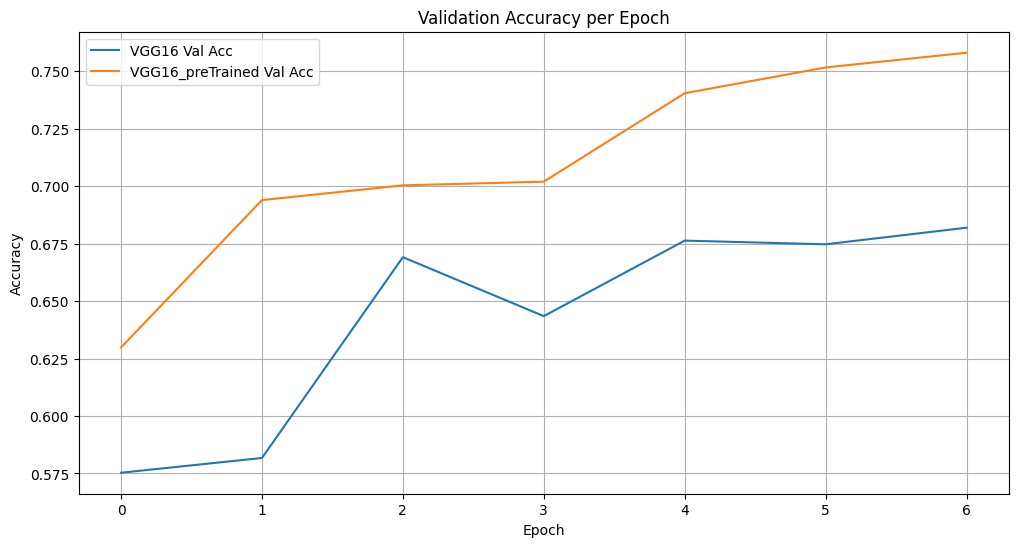

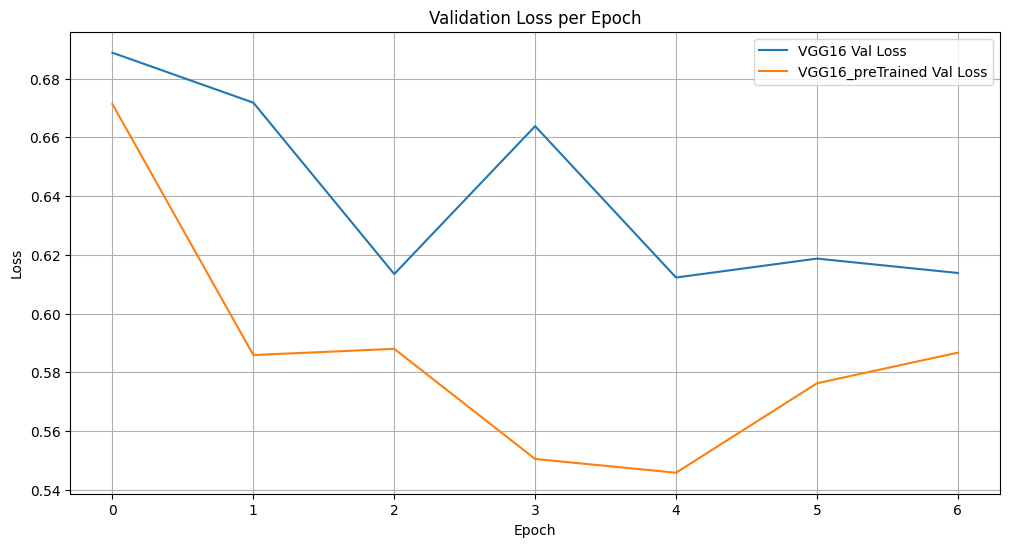

27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.7245 - loss: 0.6302
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.7682 - loss: 0.5423


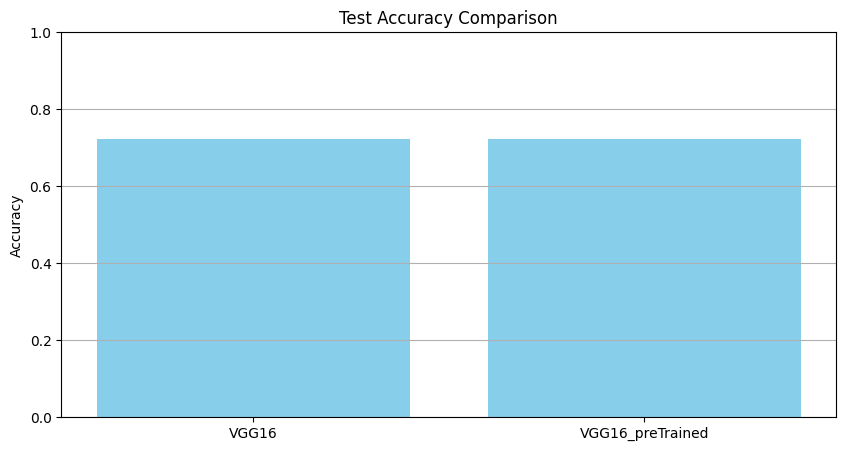

In [70]:
import matplotlib.pyplot as plt

# Extract history data
histories = {
    "VGG16": history_vgg.history,
    "VGG16_preTrained": history_vgg_preTrained.history
}

# Plot Validation Accuracy
plt.figure(figsize=(12, 6))
for name, hist in histories.items():
    plt.plot(hist['val_accuracy'], label=f'{name} Val Acc')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation Loss
plt.figure(figsize=(12, 6))
for name, hist in histories.items():
    plt.plot(hist['val_loss'], label=f'{name} Val Loss')
plt.title('Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


vgg_test_loss, vgg_test_acc = best_vgg_model.evaluate(test_dataset)
vgg_test_loss_preTrained, vgg_test_acc_preTrained = best_vgg_model_preTrained.evaluate(test_dataset)

test_accuracies = {
    "VGG16": vgg_test_acc,
    "VGG16_preTrained": vgg_test_acc
}

# Plot Test Accuracy Comparison
plt.figure(figsize=(10, 5))
plt.bar(test_accuracies.keys(), test_accuracies.values(), color='skyblue')
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


## ResNet50 Model

### Without Pre-Trained Model:

In [39]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam

# Load pre-trained ResNet50 (exclude top)
base_resnet = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))

# Unfreeze last few layers for fine-tuning
for layer in base_resnet.layers[:-30]:
    layer.trainable = False
for layer in base_resnet.layers[-30:]:
    layer.trainable = True

# Define the model
model_resnet = models.Sequential([
    base_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

# Compile the model
model_resnet.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Print model summary
model_resnet.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,692,034 (98.01 MB)

 Trainable params: 16,552,450 (63.14 MB)

 Non-trainable params: 9,139,584 (34.86 MB)

In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Save best model based on validation accuracy
checkpoint_file = "best_resnet_model.h5"

callbacks = [
    ModelCheckpoint(checkpoint_file, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
]


In [41]:
resnet_history = model_resnet.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=7,
    batch_size=16,
    callbacks=callbacks
)


Epoch 1/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5505 - loss: 0.9928
Epoch 1: val_accuracy improved from -inf to 0.53125, saving model to best_resnet_model.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 63s 102ms/step - accuracy: 0.5506 - loss: 0.9926 - val_accuracy: 0.5312 - val_loss: 0.9528
Epoch 2/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5936 - loss: 0.8097
Epoch 2: val_accuracy improved from 0.53125 to 0.63221, saving model to best_resnet_model.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 43s 102ms/step - accuracy: 0.5936 - loss: 0.8097 - val_accuracy: 0.6322 - val_loss: 0.6583
Epoch 3/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6068 - loss: 0.7839
Epoch 3: val_accuracy did not improve from 0.63221
420/420 ━━━━━━━━━━━━━━━━━━━━ 38s 90ms/step - accuracy: 0.6068 - loss: 0.7839 - val_accuracy: 0.5529 - val_loss: 0.8099
Epoch 4/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5942 - loss: 0.7739
Epoch 4: val_accuracy did not improve from 0.63221
420/420 ━━━━━━━━━━━━━━━━━━━━ 37s 89ms/step - accuracy: 0.5942 - loss: 0.7738 - val_accuracy: 0.4920 - val_loss: 1.3876
Epoch 5/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6245 - loss: 0.7109
Epoch 5: val_accuracy did not improve from 0.63221
420/420 ━━━━━━━━━━━━━━━━━━━━ 37s 89ms/step - accuracy: 0.6245 - loss: 0.7108 - val_accuracy: 0.6282 - val_loss: 0.8406


In [42]:
from tensorflow.keras.models import load_model

# Load best saved model
best_resnet_model = load_model("best_resnet_model.h5")

# Evaluate on test dataset
test_loss, test_accuracy = best_resnet_model.evaluate(test_dataset)
print(f"ResNet50 Best Model Test Accuracy: {test_accuracy:.4f}")


27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.6258 - loss: 0.6526
ResNet50 Best Model Test Accuracy: 0.6154


### With Pre-Trained Model

In [43]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam

# Load pre-trained ResNet50 (exclude top)
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze last few layers for fine-tuning
for layer in base_resnet.layers[:-30]:
    layer.trainable = False
for layer in base_resnet.layers[-30:]:
    layer.trainable = True

# Define the model
model_resnet = models.Sequential([
    base_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

# Compile the model
model_resnet.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Print model summary
model_resnet.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,692,034 (98.01 MB)

 Trainable params: 16,552,450 (63.14 MB)

 Non-trainable params: 9,139,584 (34.86 MB)

In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Save best model based on validation accuracy
checkpoint_file = "best_resnet_model_preTrained.h5"

callbacks = [
    ModelCheckpoint(checkpoint_file, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
]


In [45]:
resnet_history_preTrained = model_resnet.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=7,
    batch_size=16,
    callbacks=callbacks
)


Epoch 1/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6338 - loss: 0.9600
Epoch 1: val_accuracy improved from -inf to 0.69952, saving model to best_resnet_model_preTrained.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 61s 101ms/step - accuracy: 0.6338 - loss: 0.9598 - val_accuracy: 0.6995 - val_loss: 0.9046
Epoch 2/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7169 - loss: 0.6652
Epoch 2: val_accuracy improved from 0.69952 to 0.74119, saving model to best_resnet_model_preTrained.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 38s 90ms/step - accuracy: 0.7170 - loss: 0.6651 - val_accuracy: 0.7412 - val_loss: 0.6497
Epoch 3/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7869 - loss: 0.5250
Epoch 3: val_accuracy improved from 0.74119 to 0.74840, saving model to best_resnet_model_preTrained.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 39s 92ms/step - accuracy: 0.7869 - loss: 0.5248 - val_accuracy: 0.7484 - val_loss: 0.6348
Epoch 4/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8364 - loss: 0.4037
Epoch 4: val_accuracy improved from 0.74840 to 0.76683, saving model to best_resnet_model_preTrained.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 39s 92ms/step - accuracy: 0.8365 - loss: 0.4036 - val_accuracy: 0.7668 - val_loss: 0.6419
Epoch 5/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9036 - loss: 0.2433
Epoch 5: val_accuracy improved from 0.76683 to 0.78365, saving model to best_resnet_model_preTrained.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 38s 90ms/step - accuracy: 0.9036 - loss: 0.2433 - val_accuracy: 0.7837 - val_loss: 0.6046
Epoch 6/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9103 - loss: 0.2322
Epoch 6: val_accuracy did not improve from 0.78365
420/420 ━━━━━━━━━━━━━━━━━━━━ 37s 87ms/step - accuracy: 0.9103 - loss: 0.2322 - val_accuracy: 0.7484 - val_loss: 0.9639
Epoch 7/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9189 - loss: 0.2038
Epoch 7: val_accuracy did not improve from 0.78365
420/420 ━━━━━━━━━━━━━━━━━━━━ 37s 87ms/step - accuracy: 0.9189 - loss: 0.2038 - val_accuracy: 0.7837 - val_loss: 0.7141


In [46]:
from tensorflow.keras.models import load_model

# Load best saved model
best_resnet_model_preTrained = load_model("best_resnet_model_preTrained.h5")

# Evaluate on test dataset
test_loss, test_accuracy = best_resnet_model_preTrained.evaluate(test_dataset)
print(f"ResNet50 Best Model Test Accuracy using pre Trained Model: {test_accuracy:.4f}")


27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 0.7690 - loss: 0.7151
ResNet50 Best Model Test Accuracy using pre Trained Model: 0.7646


### Comparison of ResNet50 Model with and without Pre-Trained weights:

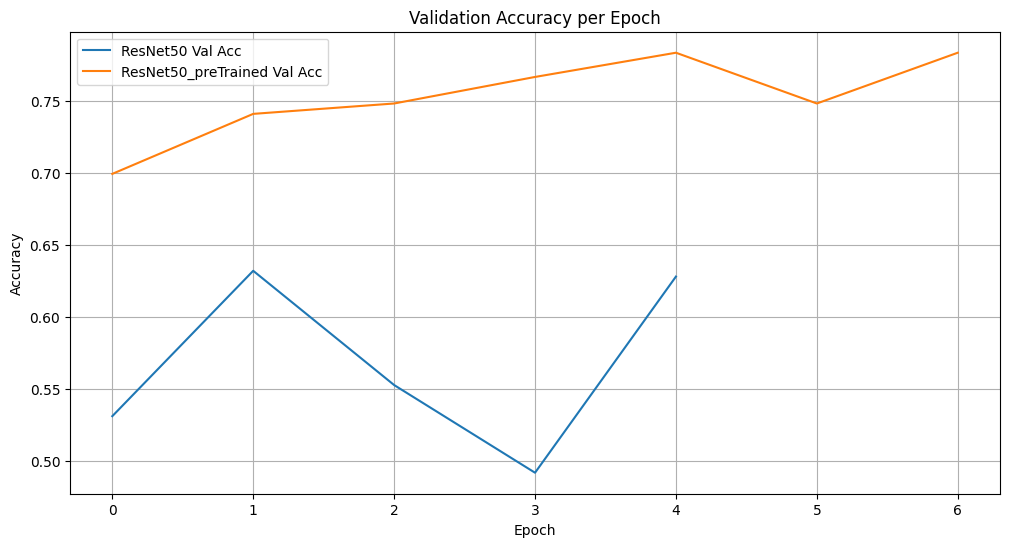

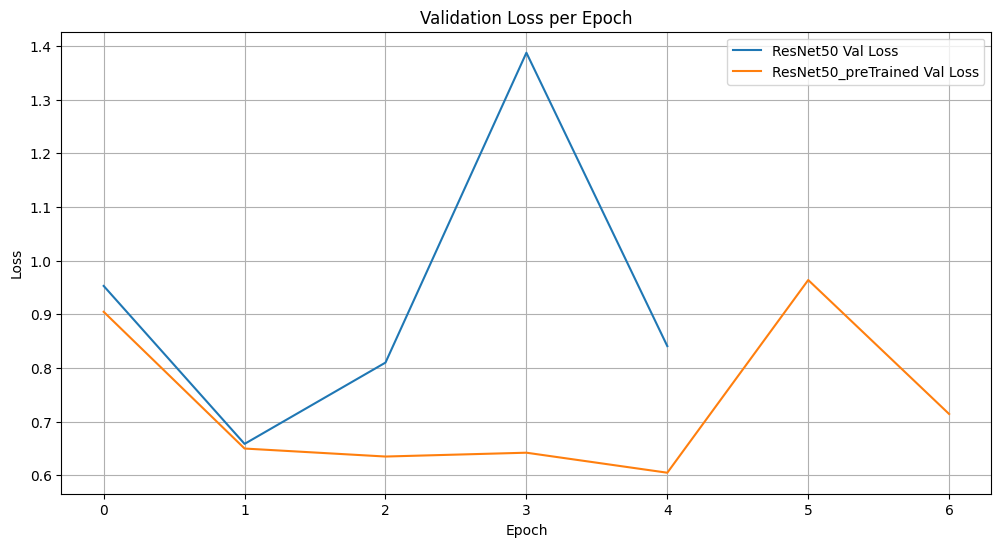

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.5858 - loss: 0.6701
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.7745 - loss: 0.6657


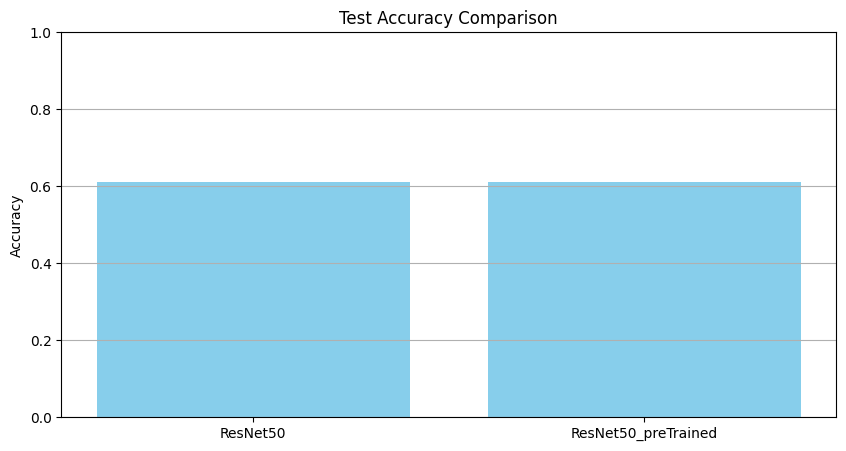

In [71]:
import matplotlib.pyplot as plt

# Extract history data
histories = {
    "ResNet50": resnet_history.history,
    "ResNet50_preTrained": resnet_history_preTrained.history
}

# Plot Validation Accuracy
plt.figure(figsize=(12, 6))
for name, hist in histories.items():
    plt.plot(hist['val_accuracy'], label=f'{name} Val Acc')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation Loss
plt.figure(figsize=(12, 6))
for name, hist in histories.items():
    plt.plot(hist['val_loss'], label=f'{name} Val Loss')
plt.title('Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


resnet_test_loss, resnet_test_acc = best_resnet_model.evaluate(test_dataset)
resnet_test_loss_preTrained, resnet_test_acc_preTrained = best_resnet_model_preTrained.evaluate(test_dataset)

test_accuracies = {
    "ResNet50": resnet_test_acc,
    "ResNet50_preTrained": resnet_test_acc
}

# Plot Test Accuracy Comparison
plt.figure(figsize=(10, 5))
plt.bar(test_accuracies.keys(), test_accuracies.values(), color='skyblue')
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

## DenseNet121 Model

### Without Pre-Trained Model:

In [47]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam

# Load base DenseNet121 (without top classifier)
base_densenet = DenseNet121(weights=None, include_top=False, input_shape=(224, 224, 3))

# Unfreeze last 10 layers for fine-tuning
for layer in base_densenet.layers[:-100]:
    layer.trainable = False
for layer in base_densenet.layers[-100:]:
    layer.trainable = True

# Build the model
model_densenet = models.Sequential([
    base_densenet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # For binary classification
])

# Compile
model_densenet.compile(optimizer=Adam(learning_rate=1e-4),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Summary
model_densenet.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,089,154 (30.86 MB)

 Trainable params: 3,000,258 (11.45 MB)

 Non-trainable params: 5,088,896 (19.41 MB)

In [48]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_file = "best_densenet_model.h5"

callbacks = [
    ModelCheckpoint(checkpoint_file, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
]


In [49]:
densenet_history = model_densenet.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=7,
    batch_size=16,
    callbacks=callbacks
)


Epoch 1/7
419/420 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5623 - loss: 0.7183
Epoch 1: val_accuracy improved from -inf to 0.57372, saving model to best_densenet_model.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 98s 109ms/step - accuracy: 0.5625 - loss: 0.7181 - val_accuracy: 0.5737 - val_loss: 0.6691
Epoch 2/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6452 - loss: 0.6359
Epoch 2: val_accuracy improved from 0.57372 to 0.58494, saving model to best_densenet_model.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 43s 79ms/step - accuracy: 0.6453 - loss: 0.6359 - val_accuracy: 0.5849 - val_loss: 0.7324
Epoch 3/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6594 - loss: 0.6081
Epoch 3: val_accuracy improved from 0.58494 to 0.64583, saving model to best_densenet_model.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 39s 73ms/step - accuracy: 0.6595 - loss: 0.6081 - val_accuracy: 0.6458 - val_loss: 0.6390
Epoch 4/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6851 - loss: 0.5867
Epoch 4: val_accuracy did not improve from 0.64583
420/420 ━━━━━━━━━━━━━━━━━━━━ 32s 76ms/step - accuracy: 0.6851 - loss: 0.5867 - val_accuracy: 0.5481 - val_loss: 0.8781
Epoch 5/7
419/420 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6980 - loss: 0.5817
Epoch 5: val_accuracy did not improve from 0.64583
420/420 ━━━━━━━━━━━━━━━━━━━━ 28s 67ms/step - accuracy: 0.6980 - loss: 0.5816 - val_accuracy: 0.6266 - val_loss: 0.6988
Epoch 6/7
419/420 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7089 - loss: 0.5652
Epoch 6: val_accuracy did not improve from 0.64583
420/420 ━━━━━━━━━━━━━━━━━━━━ 27s 65ms/step - accuracy: 0.7090 - loss: 0.5651 - val_accuracy: 0.6258 - val_loss: 0.6923


In [50]:
from tensorflow.keras.models import load_model

# Load best DenseNet121 model
best_densenet_model = load_model("best_densenet_model.h5")

# Evaluate on test dataset
test_loss, test_accuracy = best_densenet_model.evaluate(test_dataset)
print(f"DenseNet121 Best Model Test Accuracy with pre trained model: {test_accuracy:.4f}")


27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 526ms/step - accuracy: 0.6332 - loss: 0.6857
DenseNet121 Best Model Test Accuracy with pre trained model: 0.6131


### With Pre-Trained Model:

In [51]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam

# Load base DenseNet121 (without top classifier)
base_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze last 10 layers for fine-tuning
for layer in base_densenet.layers[:-100]:
    layer.trainable = False
for layer in base_densenet.layers[-100:]:
    layer.trainable = True

# Build the model
model_densenet = models.Sequential([
    base_densenet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # For binary classification
])

# Compile
model_densenet.compile(optimizer=Adam(learning_rate=1e-4),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Summary
model_densenet.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,089,154 (30.86 MB)

 Trainable params: 3,000,258 (11.45 MB)

 Non-trainable params: 5,088,896 (19.41 MB)

In [52]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_file = "best_densenet_model_preTrained.h5"

callbacks = [
    ModelCheckpoint(checkpoint_file, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
]


In [53]:
densenet_history_preTrained = model_densenet.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=7,
    batch_size=16,
    callbacks=callbacks
)


Epoch 1/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6390 - loss: 0.7105
Epoch 1: val_accuracy improved from -inf to 0.72516, saving model to best_densenet_model_preTrained.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 95s 100ms/step - accuracy: 0.6391 - loss: 0.7104 - val_accuracy: 0.7252 - val_loss: 0.5448
Epoch 2/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7130 - loss: 0.5544
Epoch 2: val_accuracy improved from 0.72516 to 0.72756, saving model to best_densenet_model_preTrained.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 34s 80ms/step - accuracy: 0.7130 - loss: 0.5544 - val_accuracy: 0.7276 - val_loss: 0.5441
Epoch 3/7
419/420 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7635 - loss: 0.4872
Epoch 3: val_accuracy improved from 0.72756 to 0.74760, saving model to best_densenet_model_preTrained.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 29s 68ms/step - accuracy: 0.7635 - loss: 0.4871 - val_accuracy: 0.7476 - val_loss: 0.5132
Epoch 4/7
419/420 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8034 - loss: 0.4007
Epoch 4: val_accuracy improved from 0.74760 to 0.75801, saving model to best_densenet_model_preTrained.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 30s 70ms/step - accuracy: 0.8035 - loss: 0.4006 - val_accuracy: 0.7580 - val_loss: 0.5470
Epoch 5/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8386 - loss: 0.3466
Epoch 5: val_accuracy did not improve from 0.75801
420/420 ━━━━━━━━━━━━━━━━━━━━ 27s 65ms/step - accuracy: 0.8386 - loss: 0.3465 - val_accuracy: 0.7452 - val_loss: 0.6451
Epoch 6/7
419/420 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8806 - loss: 0.2776
Epoch 6: val_accuracy did not improve from 0.75801
420/420 ━━━━━━━━━━━━━━━━━━━━ 46s 78ms/step - accuracy: 0.8807 - loss: 0.2775 - val_accuracy: 0.7196 - val_loss: 0.7761
Epoch 7/7
419/420 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9018 - loss: 0.2268
Epoch 7: val_accuracy improved from 0.75801 to 0.77804, saving model to best_densenet_model_preTrained.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 28s 66ms/step - accuracy: 0.9019 - loss: 0.2267 - val_accuracy: 0.7780 - val_loss: 0.6895


In [54]:
from tensorflow.keras.models import load_model

# Load best DenseNet121 model
best_densenet_model_preTrained = load_model("best_densenet_model_preTrained.h5")

# Evaluate on test dataset
test_loss, test_accuracy = best_densenet_model_preTrained.evaluate(test_dataset)
print(f"DenseNet121 Best Model Test Accuracy with pre trained model: {test_accuracy:.4f}")


27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 268ms/step - accuracy: 0.7604 - loss: 0.8432
DenseNet121 Best Model Test Accuracy with pre trained model: 0.7692


### Comparison

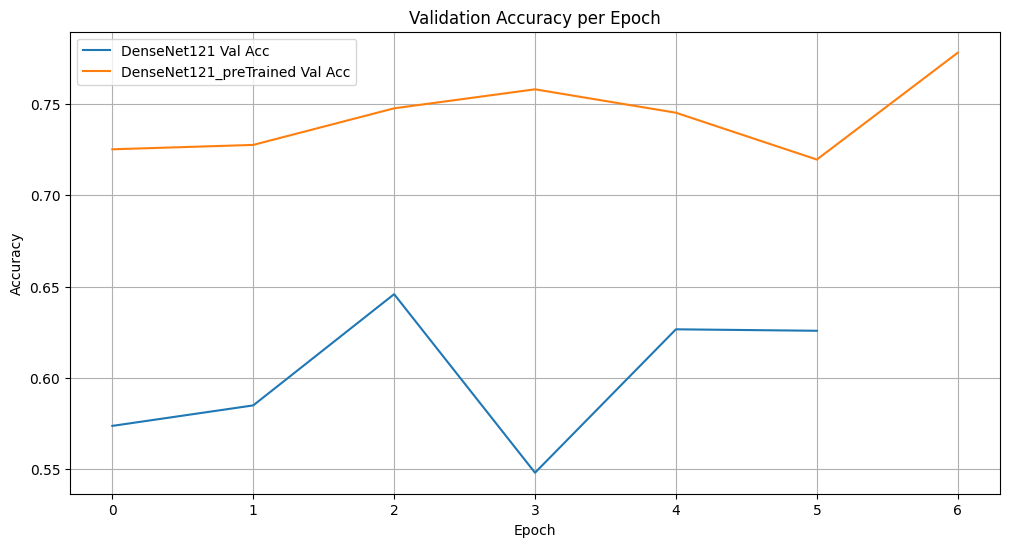

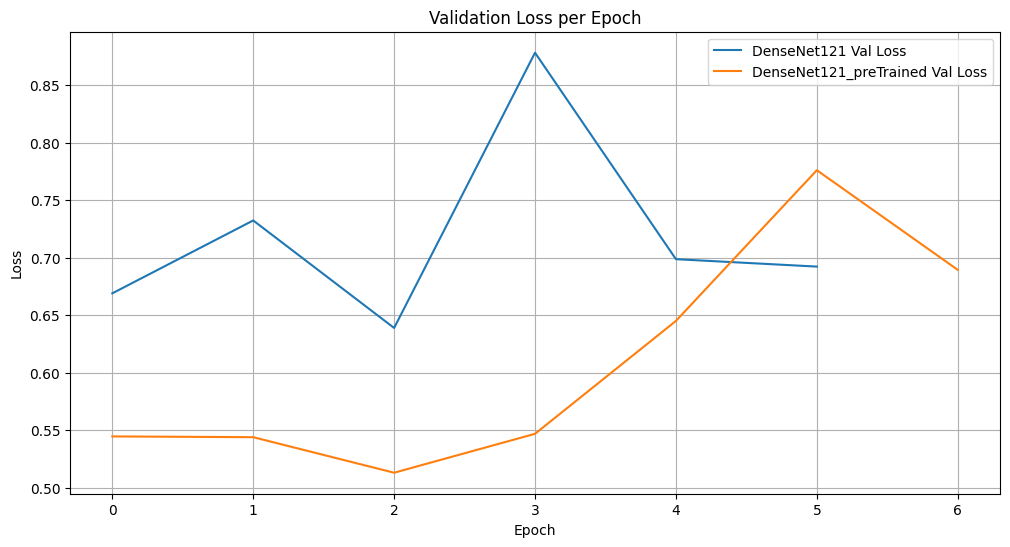

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.6118 - loss: 0.6671
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.7883 - loss: 0.7231


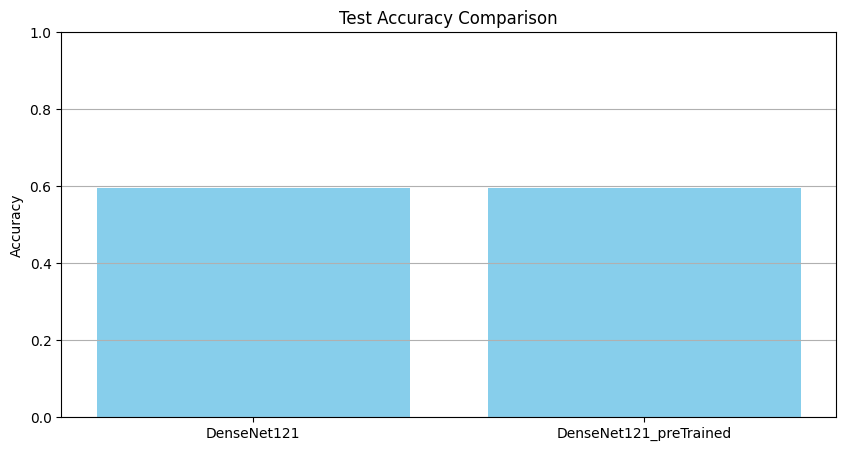

In [72]:
import matplotlib.pyplot as plt

# Extract history data
histories = {
    "DenseNet121": densenet_history.history,
    "DenseNet121_preTrained": densenet_history_preTrained.history
}

# Plot Validation Accuracy
plt.figure(figsize=(12, 6))
for name, hist in histories.items():
    plt.plot(hist['val_accuracy'], label=f'{name} Val Acc')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation Loss
plt.figure(figsize=(12, 6))
for name, hist in histories.items():
    plt.plot(hist['val_loss'], label=f'{name} Val Loss')
plt.title('Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


densenet_test_loss, densenet_test_acc = best_densenet_model.evaluate(test_dataset)
densenet_test_loss_preTrained, densenet_test_acc_preTrained = best_densenet_model_preTrained.evaluate(test_dataset)

test_accuracies = {
    "DenseNet121": densenet_test_acc,
    "DenseNet121_preTrained": densenet_test_acc
}

# Plot Test Accuracy Comparison
plt.figure(figsize=(10, 5))
plt.bar(test_accuracies.keys(), test_accuracies.values(), color='skyblue')
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

## MobileNet Model

### Without Pre-Trained weights:

In [55]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 base model (no top, pretrained on ImageNet)
base_mobilenet = MobileNetV2(weights=None , include_top=False, input_shape=(224, 224, 3))

# Unfreeze last 10 layers for fine-tuning
for layer in base_mobilenet.layers[:-120]:
    layer.trainable = False
for layer in base_mobilenet.layers[-120:]:
    layer.trainable = True

# Build full model
model_mobilenet = models.Sequential([
    base_mobilenet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # 2-class classifier
])

# Compile the model
model_mobilenet.compile(optimizer=Adam(learning_rate=1e-4),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

# Print model summary
model_mobilenet.summary()


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,571,778 (13.63 MB)

 Trainable params: 3,516,546 (13.41 MB)

 Non-trainable params: 55,232 (215.75 KB)

In [56]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_file = "best_mobilenet_model.h5"

callbacks = [
    ModelCheckpoint(checkpoint_file, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
]


In [57]:
mobilenet_history = model_mobilenet.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=7,
    callbacks=callbacks,
    batch_size=16
)


Epoch 1/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5123 - loss: 0.7457
Epoch 1: val_accuracy improved from -inf to 0.50962, saving model to best_mobilenet_model.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 64s 58ms/step - accuracy: 0.5123 - loss: 0.7456 - val_accuracy: 0.5096 - val_loss: 0.6930
Epoch 2/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5578 - loss: 0.6885
Epoch 2: val_accuracy did not improve from 0.50962
420/420 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.5578 - loss: 0.6885 - val_accuracy: 0.5048 - val_loss: 0.6937
Epoch 3/7
419/420 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5944 - loss: 0.6588
Epoch 3: val_accuracy did not improve from 0.50962
420/420 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.5945 - loss: 0.6588 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 4/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6291 - loss: 0.6285
Epoch 4: val_accuracy did not improve from 0.50962
420/420 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.6291 - loss: 0.6285 - val_accuracy: 0.5008 - val_loss: 0.6967


In [58]:
from tensorflow.keras.models import load_model

# Load best MobileNet model
best_mobilenet_model = load_model("best_mobilenet_model.h5")

# Evaluate
test_loss, test_accuracy = best_mobilenet_model.evaluate(test_dataset)
print(f"MobileNetV2 Best Model Test Accuracy: {test_accuracy:.4f}")


27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.5324 - loss: 0.6916
MobileNetV2 Best Model Test Accuracy: 0.5105


### With Pre-Trained weights:

In [59]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 base model (no top, pretrained on ImageNet)
base_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze last 10 layers for fine-tuning
for layer in base_mobilenet.layers[:-120]:
    layer.trainable = False
for layer in base_mobilenet.layers[-120:]:
    layer.trainable = True

# Build full model
model_mobilenet = models.Sequential([
    base_mobilenet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # 2-class classifier
])

# Compile the model
model_mobilenet.compile(optimizer=Adam(learning_rate=1e-4),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

# Print model summary
model_mobilenet.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,571,778 (13.63 MB)

 Trainable params: 3,516,546 (13.41 MB)

 Non-trainable params: 55,232 (215.75 KB)

In [60]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_file = "best_mobilenet_model_preTrained.h5"

callbacks = [
    ModelCheckpoint(checkpoint_file, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
]


In [61]:
mobilenet_history_preTrained = model_mobilenet.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=7,
    callbacks=callbacks,
    batch_size=16
)


Epoch 1/7
419/420 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5407 - loss: 0.7498
Epoch 1: val_accuracy improved from -inf to 0.57772, saving model to best_mobilenet_model_preTrained.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 63s 56ms/step - accuracy: 0.5409 - loss: 0.7496 - val_accuracy: 0.5777 - val_loss: 0.6788
Epoch 2/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6692 - loss: 0.5970
Epoch 2: val_accuracy did not improve from 0.57772
420/420 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.6692 - loss: 0.5970 - val_accuracy: 0.5409 - val_loss: 0.8120
Epoch 3/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7330 - loss: 0.5314
Epoch 3: val_accuracy improved from 0.57772 to 0.63301, saving model to best_mobilenet_model_preTrained.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.7330 - loss: 0.5314 - val_accuracy: 0.6330 - val_loss: 0.7237
Epoch 4/7
419/420 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8000 - loss: 0.4234
Epoch 4: val_accuracy did not improve from 0.63301
420/420 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.8001 - loss: 0.4233 - val_accuracy: 0.5986 - val_loss: 0.7362
Epoch 5/7
419/420 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8680 - loss: 0.3041
Epoch 5: val_accuracy improved from 0.63301 to 0.66266, saving model to best_mobilenet_model_preTrained.h5


420/420 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.8681 - loss: 0.3039 - val_accuracy: 0.6627 - val_loss: 0.8676
Epoch 6/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9126 - loss: 0.2191
Epoch 6: val_accuracy did not improve from 0.66266
420/420 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9127 - loss: 0.2191 - val_accuracy: 0.6506 - val_loss: 1.1528
Epoch 7/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9327 - loss: 0.1726
Epoch 7: val_accuracy did not improve from 0.66266
420/420 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9327 - loss: 0.1726 - val_accuracy: 0.6298 - val_loss: 1.3130


In [62]:
from tensorflow.keras.models import load_model

# Load best MobileNet model
best_mobilenet_model_preTrained = load_model("best_mobilenet_model_preTrained.h5")

# Evaluate
test_loss, test_accuracy = best_mobilenet_model_preTrained.evaluate(test_dataset)
print(f"MobileNetV2 Best Model Test Accuracy with Pre-Trained Model: {test_accuracy:.4f}")


27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.6289 - loss: 0.9335
MobileNetV2 Best Model Test Accuracy with Pre-Trained Model: 0.6294


### Comparison

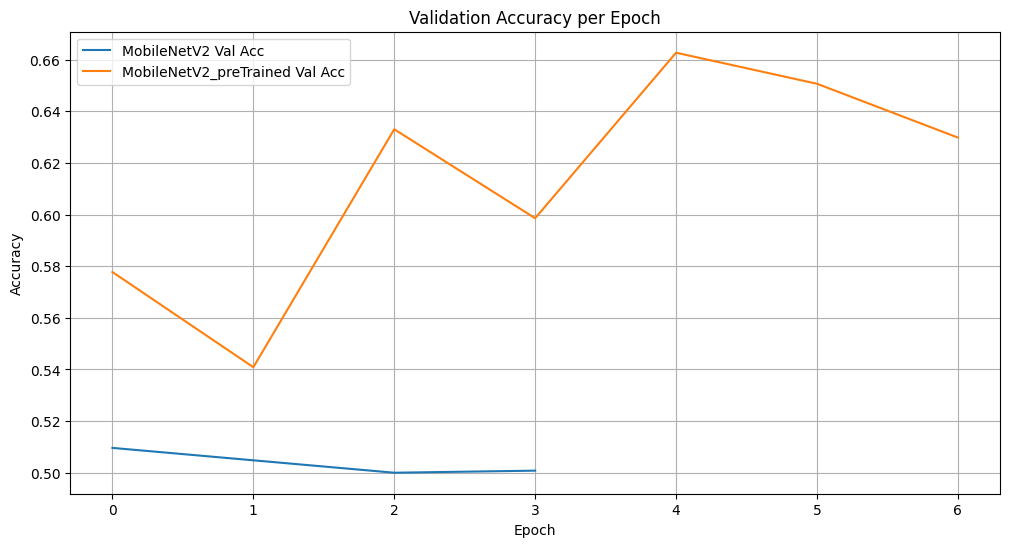

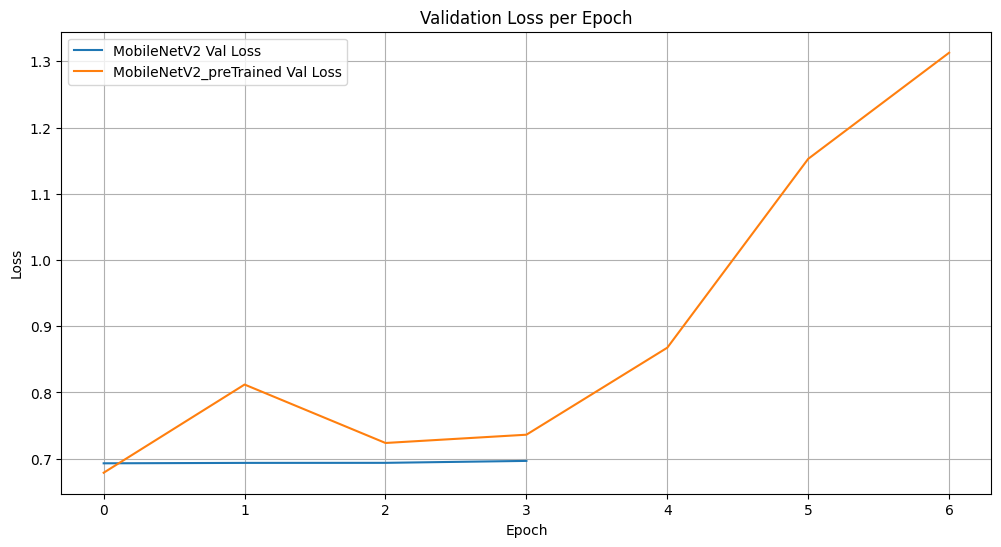

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5305 - loss: 0.6917
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6335 - loss: 0.9287


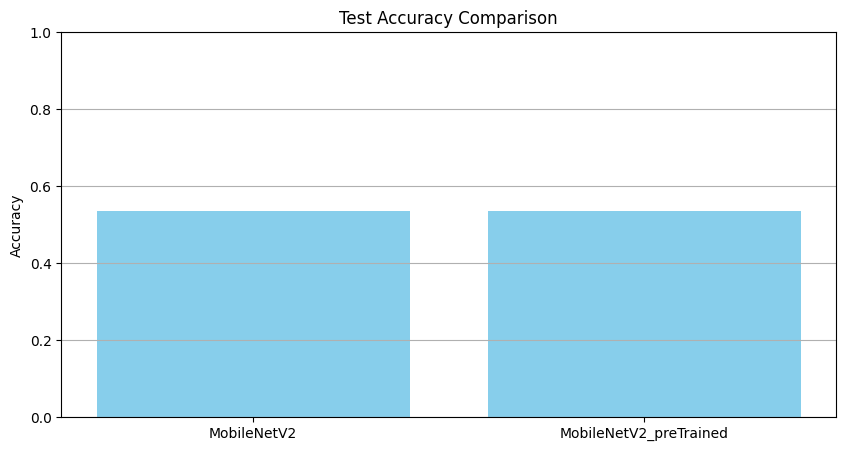

In [73]:
import matplotlib.pyplot as plt

# Extract history data
histories = {
    "MobileNetV2": mobilenet_history.history,
    "MobileNetV2_preTrained": mobilenet_history_preTrained.history
}

# Plot Validation Accuracy
plt.figure(figsize=(12, 6))
for name, hist in histories.items():
    plt.plot(hist['val_accuracy'], label=f'{name} Val Acc')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation Loss
plt.figure(figsize=(12, 6))
for name, hist in histories.items():
    plt.plot(hist['val_loss'], label=f'{name} Val Loss')
plt.title('Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


mobilenet_test_loss, mobilenet_test_acc = best_mobilenet_model.evaluate(test_dataset)
mobilenet_test_loss_preTrained, mobilenet_test_acc_preTrained = best_mobilenet_model_preTrained.evaluate(test_dataset)

test_accuracies = {
    "MobileNetV2": mobilenet_test_acc,
    "MobileNetV2_preTrained": mobilenet_test_acc
}

# Plot Test Accuracy Comparison
plt.figure(figsize=(10, 5))
plt.bar(test_accuracies.keys(), test_accuracies.values(), color='skyblue')
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

##Vision Transformers

In [63]:
!pip install transformers


In [64]:
from transformers import TFViTModel
from tensorflow.keras import layers, Model, Input
import tensorflow as tf

# Load pretrained ViT backbone
vit_backbone = TFViTModel.from_pretrained("google/vit-base-patch16-224")
vit_backbone.trainable = False

class ViTLayer(layers.Layer):
    def __init__(self, vit_model):
        super(ViTLayer, self).__init__()
        self.vit_model = vit_model
        # Store the correct identifier
        self.vit_model_identifier = "google/vit-base-patch16-224"

    def call(self, inputs):
        inputs = tf.transpose(inputs, perm=[0, 3, 1, 2])
        outputs = self.vit_model(inputs, training=False)
        return outputs.last_hidden_state[:, 0, :]

    def get_config(self):
        config = super().get_config().copy()
        # Ensure the correct identifier is saved in the config
        config.update({
            'vit_model': self.vit_model_identifier,
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Load using the saved identifier
        vit_model = TFViTModel.from_pretrained(config['vit_model'])
        return cls(vit_model)

inputs = Input(shape=(224, 224, 3), name="input_image")
x = layers.Rescaling(1./255)(inputs)

# Wrap ViT backbone
cls_token = ViTLayer(vit_backbone)(x)

# Classifier head
x = layers.Dense(512, activation='relu')(cls_token)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(2, activation='softmax')(x)

# Final model
vit_model = Model(inputs=inputs, outputs=outputs)

summary_string = vit_model.summary()
print(summary_string)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "functional_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vi_t_layer (ViTLayer)           │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 462,210 (1.76 MB)

 Trainable params: 460,930 (1.76 MB)

 Non-trainable params: 1,280 (5.00 KB)

None


In [65]:
vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


In [66]:
vit_history = vit_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=7,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(
    "best_vit_model.keras",         # no file extension = SavedModel format
    save_best_only=True,
    # save_format="tf"                    # ensures SavedModel format
)
    ]
)


Epoch 1/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 124s 220ms/step - accuracy: 0.5552 - loss: 0.9710 - precision: 0.5552 - recall: 0.5552 - val_accuracy: 0.6571 - val_loss: 0.6441 - val_precision: 0.6571 - val_recall: 0.6571
Epoch 2/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 90s 215ms/step - accuracy: 0.6313 - loss: 0.7567 - precision: 0.6313 - recall: 0.6313 - val_accuracy: 0.6755 - val_loss: 0.6220 - val_precision: 0.6755 - val_recall: 0.6755
Epoch 3/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 90s 214ms/step - accuracy: 0.6710 - loss: 0.6787 - precision: 0.6710 - recall: 0.6710 - val_accuracy: 0.6923 - val_loss: 0.6052 - val_precision: 0.6923 - val_recall: 0.6923
Epoch 4/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 91s 218ms/step - accuracy: 0.6705 - loss: 0.6738 - precision: 0.6705 - recall: 0.6705 - val_accuracy: 0.7019 - val_loss: 0.5942 - val_precision: 0.7019 - val_recall: 0.7019
Epoch 5/7
420/420 ━━━━━━━━━━━━━━━━━━━━ 139s 211ms/step - accuracy: 0.6978 - loss: 0.6204 - precision: 0.6978 - recall: 0.6978 - val_accuracy: 0.7019 - 

In [67]:
from tensorflow.keras.models import load_model

# Load the best model
best_vit_model = load_model("best_vit_model.keras", custom_objects={'ViTLayer': ViTLayer})
test_loss, test_accuracy, test_precision, test_recall = best_vit_model.evaluate(test_dataset)

print(f"Test Accuracy:  {test_accuracy:.4f}")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 303ms/step - accuracy: 0.7251 - loss: 0.5670 - precision: 0.7251 - recall: 0.7251
Test Accuracy:  0.7273


## Evaluation Metrics & Visualisation

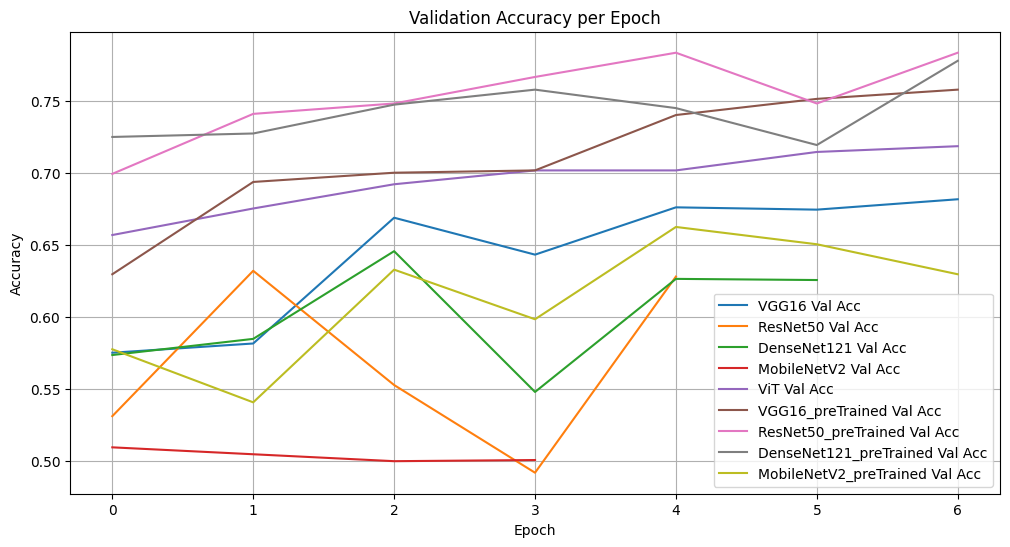

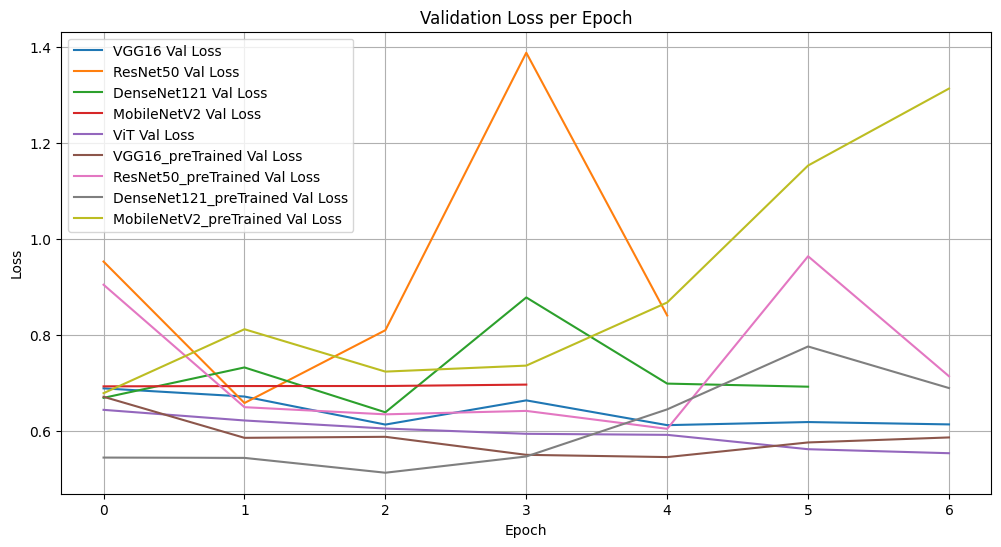

In [68]:
import matplotlib.pyplot as plt

# Extract history data
histories = {
    "VGG16": history_vgg.history,
    "ResNet50": resnet_history.history,
    "DenseNet121": densenet_history.history,
    "MobileNetV2": mobilenet_history.history,
    "ViT": vit_history.history,
    "VGG16_preTrained": history_vgg_preTrained.history,
    "ResNet50_preTrained": resnet_history_preTrained.history,
    "DenseNet121_preTrained": densenet_history_preTrained.history,
    "MobileNetV2_preTrained": mobilenet_history_preTrained.history
}

# Plot Validation Accuracy
plt.figure(figsize=(12, 6))
for name, hist in histories.items():
    plt.plot(hist['val_accuracy'], label=f'{name} Val Acc')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation Loss
plt.figure(figsize=(12, 6))
for name, hist in histories.items():
    plt.plot(hist['val_loss'], label=f'{name} Val Loss')
plt.title('Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.7492 - loss: 0.5641
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.6062 - loss: 0.6640
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.6233 - loss: 0.6974
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5171 - loss: 0.6926
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.7305 - loss: 0.5703 - precision: 0.7305 - recall: 0.7305
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.7417 - loss: 0.6752
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.7418 - loss: 0.8035
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7712 - loss: 0.8241
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6776 - loss: 0.8896


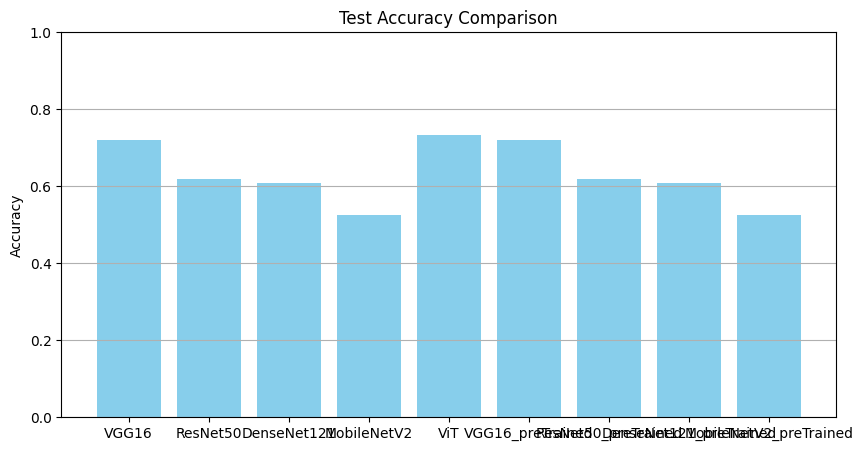

In [69]:
vgg_test_loss, vgg_test_acc = best_vgg_model.evaluate(test_dataset)
resnet_test_loss, resnet_test_acc = best_resnet_model.evaluate(test_dataset)
densenet_test_loss, densenet_test_acc = best_densenet_model.evaluate(test_dataset)
mobilenet_test_loss, mobilenet_test_acc = best_mobilenet_model.evaluate(test_dataset)
vit_test_loss, vit_test_acc, vit_precision, vit_recall = best_vit_model.evaluate(test_dataset)
vgg_test_loss_preTrained, vgg_test_acc_preTrained = best_vgg_model_preTrained.evaluate(test_dataset)
resnet_test_loss_preTrained, resnet_test_acc_preTrained = best_resnet_model_preTrained.evaluate(test_dataset)
densenet_test_loss_preTrained, densenet_test_acc_preTrained = best_densenet_model_preTrained.evaluate(test_dataset)
mobilenet_test_loss_preTrained, mobilenet_test_acc_preTrained = best_mobilenet_model_preTrained.evaluate(test_dataset)

test_accuracies = {
    "VGG16": vgg_test_acc,
    "ResNet50": resnet_test_acc,
    "DenseNet121": densenet_test_acc,
    "MobileNetV2": mobilenet_test_acc,
    "ViT": vit_test_acc,
    "VGG16_preTrained": vgg_test_acc,
    "ResNet50_preTrained": resnet_test_acc,
    "DenseNet121_preTrained": densenet_test_acc,
    "MobileNetV2_preTrained": mobilenet_test_acc
}

# Plot Test Accuracy Comparison
plt.figure(figsize=(10, 5))
plt.bar(test_accuracies.keys(), test_accuracies.values(), color='skyblue')
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

In [74]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Define evaluation function
def evaluate_model(model, test_dataset, num_classes=2):
    y_true = []
    y_pred = []
    y_score = []

    for images, labels in test_dataset:
        preds = model.predict(images)
        y_true.extend(tf.argmax(labels, axis=1).numpy())
        y_pred.extend(tf.argmax(preds, axis=1).numpy())
        y_score.extend(preds)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)
    y_true_bin = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    auc_roc = roc_auc_score(y_true_bin, y_score, average='macro')

    return accuracy, precision, recall, f1, auc_roc

# Models to evaluate
models = {
    "VGG16": best_vgg_model,
    "ResNet50": best_resnet_model,
    "DenseNet121": best_densenet_model,
    "MobileNetV2": best_mobilenet_model,
    "ViT": best_vit_model,
    "VGG16_preTrained": best_vgg_model_preTrained,
    "ResNet50_preTrained": best_resnet_model_preTrained,
    "DenseNet121_preTrained": best_densenet_model_preTrained,
    "MobileNetV2_preTrained": best_mobilenet_model_preTrained,
}

# Store results
results = {}

for name, model in models.items():
    print(f"Evaluating {name}...")
    acc, prec, rec, f1, auc = evaluate_model(model, test_dataset)
    results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "AUC-ROC": auc
    }

# Display results
for model_name, metrics in results.items():
    print("\nModel:", model_name)
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")


Evaluating VGG16...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluating ViT...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━